# Stocks

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ig
import datetime as dt
import calendar
import requests
import json

In [2]:
plt.style.use('seaborn')
graph_size=(14,10)

## API Setup

In [3]:
def login():
    details = ig.get_api('prod')
    api = ig.APIHandler(details['url'], details['api_key'], details['user_name'], details['password'])
    del details
    return api

In [4]:
api = login()
api.positions()

,bid,epic,instrumentName,offer,dealId,direction,level,limitLevel,contractSize,stopLevel,close_level,profit,stop_distance,limit_distance
0,5929.6,IX.D.FTSE.DAILY.IP,FTSE 100,5933.6,DIAAAAFMGDXM6AQ,BUY,5925.5,5998.5,0.5,5848.5,5929.6,2.05,-81.1,68.9


## Price Analysis

### Historic Price Retrieval

In [5]:
# api.markets(93334)
# api.debug_level = 1
prices = api.prices('IX.D.FTSE.DAILY.IP', resolution='DAY',
                    from_date=dt.datetime(2020, 1, 1), to_date=dt.datetime.now(),
                    show_remaining_requests=True)

Allowance Details
remainingAllowance: 9762
totalAllowance: 10000
allowanceExpiry: 6 days, 23:59:59


In [6]:
# vodafone = api.prices('KA.D.VOD.DAILY.IP', resolution='DAY',
#                     from_date=dt.datetime(2020, 1, 1), to_date=dt.datetime.now(),
#                     show_remaining_requests=True)

In [7]:
# vodafone

In [8]:
api.markets(125257)

,id,name
0,265525,Daily FTSE Options
1,182163442,OCT
2,188588728,NOV
3,159198657,DEC
4,176960455,MAR
5,194074092,JUN


### Data Manipulation

In [9]:
price_columns = [column for column in prices.columns if 'Price' in column]

for column in price_columns:
    new_columns = prices[column].apply(pd.Series)
    new_columns.columns = [column.replace('Price', '') + '_' + c for c in new_columns.columns]
    prices = prices.join(new_columns).drop(columns=column, axis=1)

In [10]:
prices = (prices.rename(columns={'snapshotTime': 'time', 'lastTradedVolume': 'volume'})
          .dropna(axis=1)
         )
prices.time = pd.to_datetime(prices.time)
prices

,time,volume,open_bid,open_ask,close_bid,close_ask,high_bid,high_ask,low_bid,low_ask
0,2020-01-01,0,7559.0,7563.0,7556.2,7560.2,7567.3,7571.3,7553.2,7557.2
1,2020-01-02,91282,7556.1,7560.1,7623.1,7627.1,7634.6,7638.6,7546.3,7549.3
2,2020-01-03,80558,7622.9,7626.9,7599.2,7603.2,7632.8,7635.8,7548.8,7549.8
3,2020-01-05,0,7576.1,7580.1,7593.3,7597.3,7595.6,7599.6,7567.4,7571.4
4,2020-01-06,80460,7593.7,7597.7,7584.6,7588.6,7598.0,7599.0,7525.8,7526.8
...,...,...,...,...,...,...,...,...,...,...
233,2020-09-30,106839,5906.2,5910.2,5868.1,5872.1,5932.7,5935.5,5833.6,5837.6
234,2020-10-01,88219,5868.3,5872.3,5877.2,5881.2,5927.2,5928.2,5847.7,5848.7
235,2020-10-02,89003,5877.3,5881.3,5907.9,5911.9,5916.9,5920.9,5793.4,5796.4
236,2020-10-04,0,5922.0,5926.0,5928.5,5932.5,5931.1,5935.1,5915.4,5919.4


### Analysis

In [11]:
prices.to_pickle('prices.pkl')

In [12]:
prices['buy_profit'] = prices.close_bid - prices.open_ask
prices['buy_stop'] = prices.low_bid - prices.open_ask
prices['buy_limit'] = prices.high_bid - prices.open_ask
prices['sell_profit'] = -(prices.close_ask - prices.open_bid)
prices['sell_stop'] = prices.high_ask - prices.open_bid
prices['sell_limit'] = prices.low_ask - prices.open_bid
prices

,time,volume,open_bid,open_ask,close_bid,close_ask,high_bid,high_ask,low_bid,low_ask,buy_profit,buy_stop,buy_limit,sell_profit,sell_stop,sell_limit
0,2020-01-01,0,7559.0,7563.0,7556.2,7560.2,7567.3,7571.3,7553.2,7557.2,-6.8,-9.8,4.3,-1.2,12.3,-1.8
1,2020-01-02,91282,7556.1,7560.1,7623.1,7627.1,7634.6,7638.6,7546.3,7549.3,63.0,-13.8,74.5,-71.0,82.5,-6.8
2,2020-01-03,80558,7622.9,7626.9,7599.2,7603.2,7632.8,7635.8,7548.8,7549.8,-27.7,-78.1,5.9,19.7,12.9,-73.1
3,2020-01-05,0,7576.1,7580.1,7593.3,7597.3,7595.6,7599.6,7567.4,7571.4,13.2,-12.7,15.5,-21.2,23.5,-4.7
4,2020-01-06,80460,7593.7,7597.7,7584.6,7588.6,7598.0,7599.0,7525.8,7526.8,-13.1,-71.9,0.3,5.1,5.3,-66.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,2020-09-30,106839,5906.2,5910.2,5868.1,5872.1,5932.7,5935.5,5833.6,5837.6,-42.1,-76.6,22.5,34.1,29.3,-68.6
234,2020-10-01,88219,5868.3,5872.3,5877.2,5881.2,5927.2,5928.2,5847.7,5848.7,4.9,-24.6,54.9,-12.9,59.9,-19.6
235,2020-10-02,89003,5877.3,5881.3,5907.9,5911.9,5916.9,5920.9,5793.4,5796.4,26.6,-87.9,35.6,-34.6,43.6,-80.9
236,2020-10-04,0,5922.0,5926.0,5928.5,5932.5,5931.1,5935.1,5915.4,5919.4,2.5,-10.6,5.1,-10.5,13.1,-2.6


In [13]:
prices[prices.time == dt.datetime(2020,8,31)].buy_profit

207   -40.8
Name: buy_profit, dtype: float64

In [14]:
mondays = prices[(prices.time.dt.weekday == 0)].copy()
fridays = prices[(prices.time.dt.weekday == 4)].copy()

#### Maximum Profit

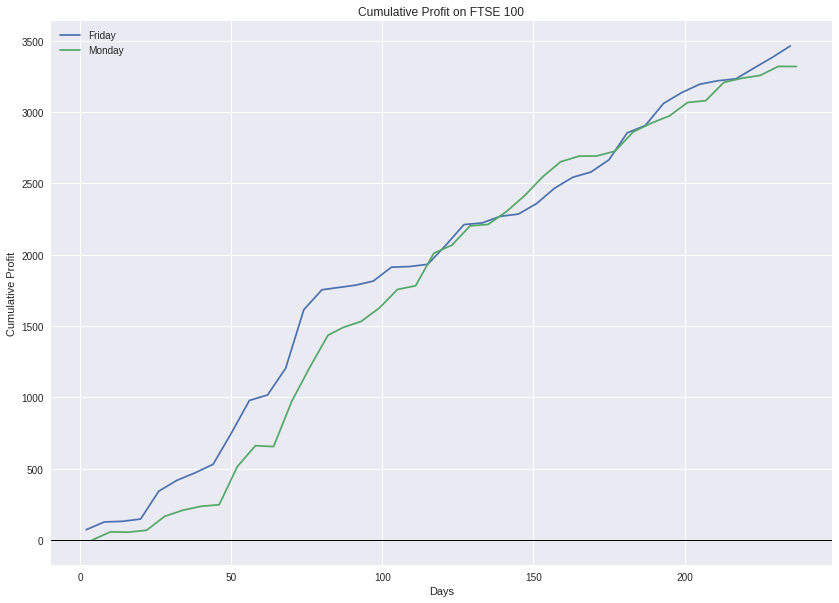

In [15]:
ax = (-fridays.sell_limit).cumsum().plot(figsize=graph_size, legend=True, title='Cumulative Profit on FTSE 100')
ax = mondays.buy_limit.cumsum().plot(figsize=graph_size, legend=True)
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative Profit')
ax.axhline(y=0, color='k', linewidth=1)
ax.legend(['Friday', 'Monday'])

#### Full-day Profit
- buy FTSE 100 on Monday 00:00 and sell Monday 23:59 (green line)
- sell FTSE 100 on Friday 00:00 and buy Friday 23:59 (buy line)

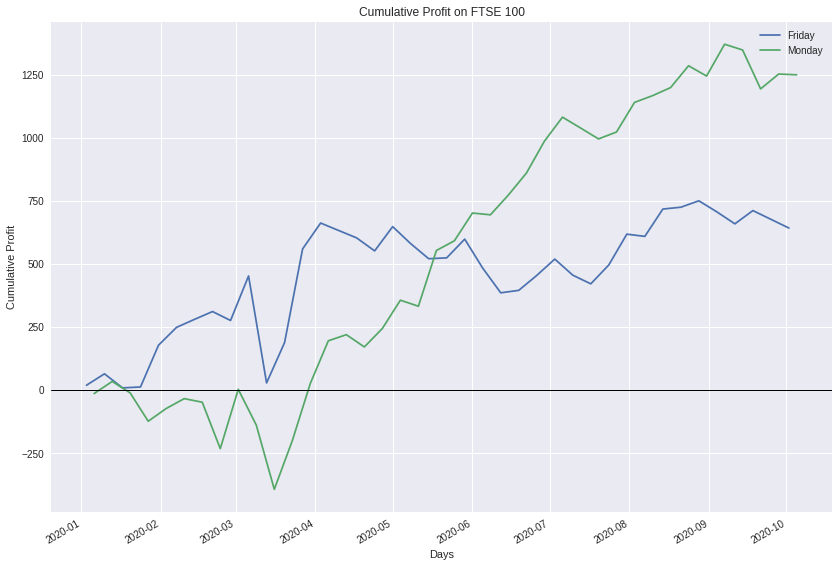

In [16]:
ax = fridays.set_index('time').sell_profit.cumsum().plot(figsize=graph_size, legend=True, title='Cumulative Profit on FTSE 100')
ax = mondays.set_index('time').buy_profit.cumsum().plot(figsize=graph_size, legend=True)
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative Profit')
ax.axhline(y=0, color='k', linewidth=1)
ax.legend(['Friday', 'Monday'])

#### Thresholds


In [17]:
def get_trades(df, stop_quantile=0.8, limit_quantile=0.8):
    quantiles = {'stop': stop_quantile, 'limit': 1 - limit_quantile}
    day = {'buy': 0, 'sell': 4}
    trade_df = pd.DataFrame(columns=['day', 'direction', 'stop', 'limit'])
    
    for direction in ['buy', 'sell']:
        day_df = df[df.time.dt.weekday == day[direction]]
        trade = {'day': calendar.day_name[day[direction]],
                 'direction': direction,
                 'stop': day_df[direction + '_' + 'stop'].apply(np.abs).quantile(stop_quantile),
                 'limit': day_df[direction + '_' + 'limit'].apply(np.abs).quantile(1 - limit_quantile)
                }
        trade_df = trade_df.append(trade, ignore_index=True)
    
    trade_df['risk_reward_ratio'] = trade_df.limit / trade_df.stop
    trade_df['expected_value'] = limit_quantile * trade_df.limit - (1 - stop_quantile) * trade_df.stop
    
    return trade_df

In [18]:
def backtest_trade(df_prices, direction='buy', stop=20, limit=40, column_name='trade'):
    day = {'buy': 0, 'sell': 4}
    
    # define results in each scenario
    def backtest(df):
        if np.abs(df[direction + '_stop']) > stop:
            return -stop
        elif np.abs(df[direction + '_limit']) > limit:
            return limit
        else:
            return df[direction + '_profit']
        
    df_prices[column_name] = df_prices.apply(backtest, axis=1)
    print(f'Summary of profit for {direction} (stop: {stop}, limit: {limit}):')
    print(f"{df_prices[df_prices.time.dt.weekday == day[direction]][column_name].agg(['count', 'sum', 'mean', 'median', 'std'])}\n")

In [19]:
num_points = 10
points = pd.Series(range(0, 100, int(100 / num_points))) / 100
dp = pd.DataFrame(columns=['limit', 'stop', 'mon_ev', 'fri_ev'])

for point in points:
    dp = dp.append(pd.DataFrame({'limit': [point] * len(points),
                                 'stop': points}), ignore_index=True)
    
for idx, row in dp.iterrows():
    trade = get_trades(prices, stop_quantile=row.stop, limit_quantile=row.limit).set_index('day')
    row['mon_ev'] = trade.at['Monday', 'expected_value']
    row['fri_ev'] = trade.at['Friday', 'expected_value']
    dp.iloc[idx] = row

dp.max()

limit      0.900
stop       0.900
mon_ev    31.912
fri_ev    32.400
dtype: float64

stop
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
0.1    AxesSubplot(0.125,0.125;0.775x0.755)
0.2    AxesSubplot(0.125,0.125;0.775x0.755)
0.3    AxesSubplot(0.125,0.125;0.775x0.755)
0.4    AxesSubplot(0.125,0.125;0.775x0.755)
0.5    AxesSubplot(0.125,0.125;0.775x0.755)
0.6    AxesSubplot(0.125,0.125;0.775x0.755)
0.7    AxesSubplot(0.125,0.125;0.775x0.755)
0.8    AxesSubplot(0.125,0.125;0.775x0.755)
0.9    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

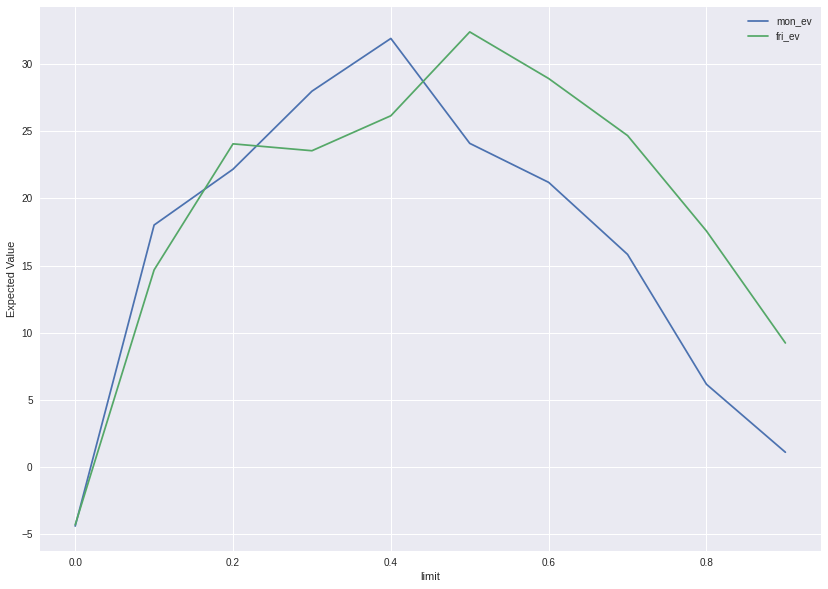

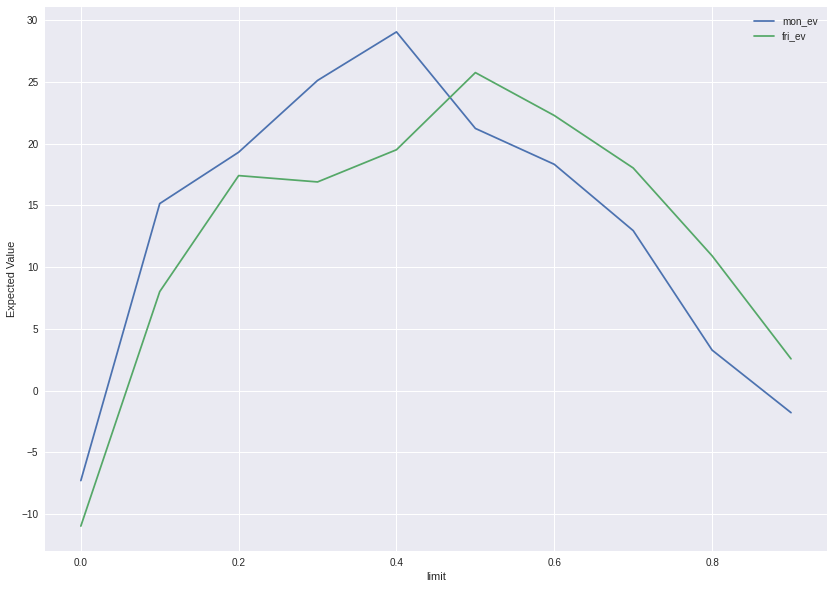

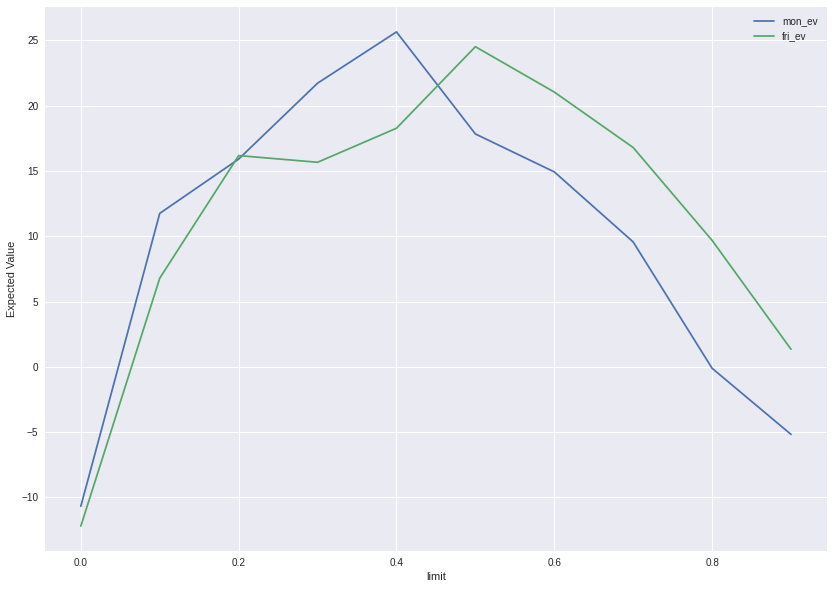

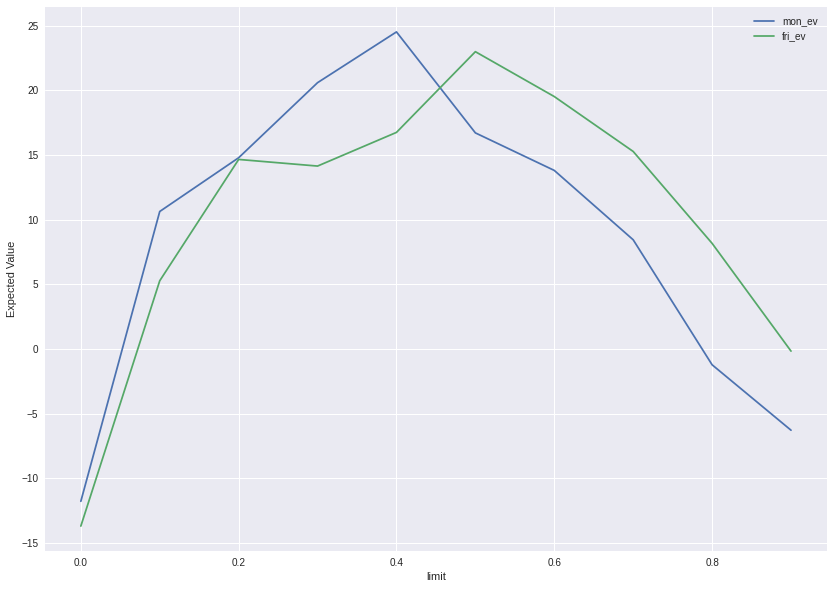

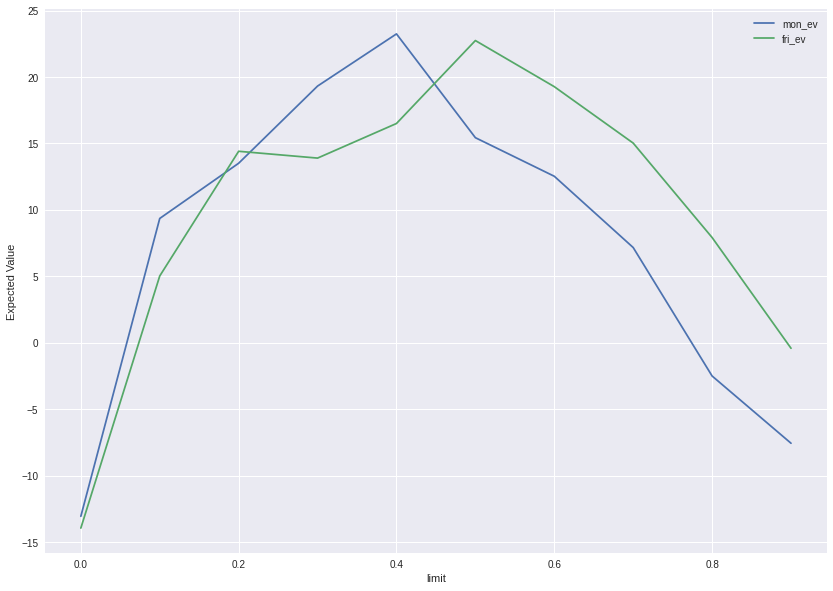

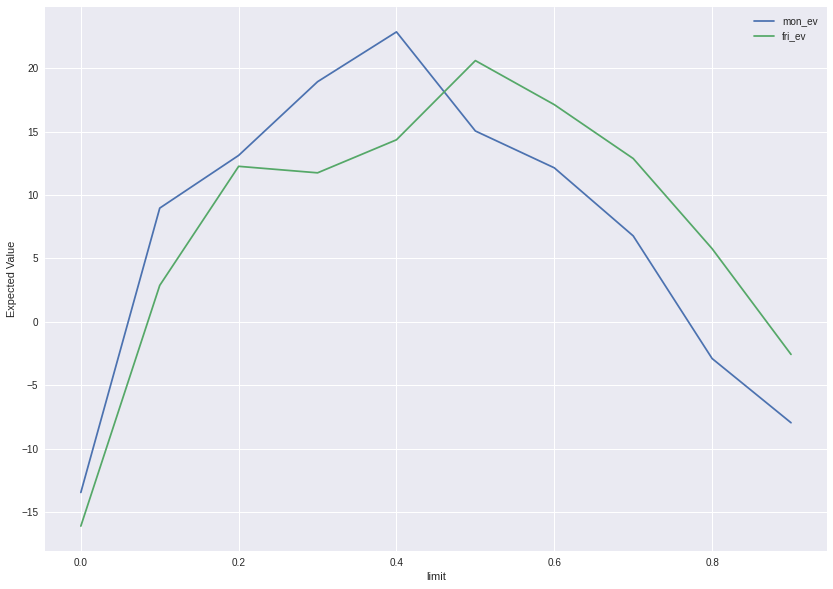

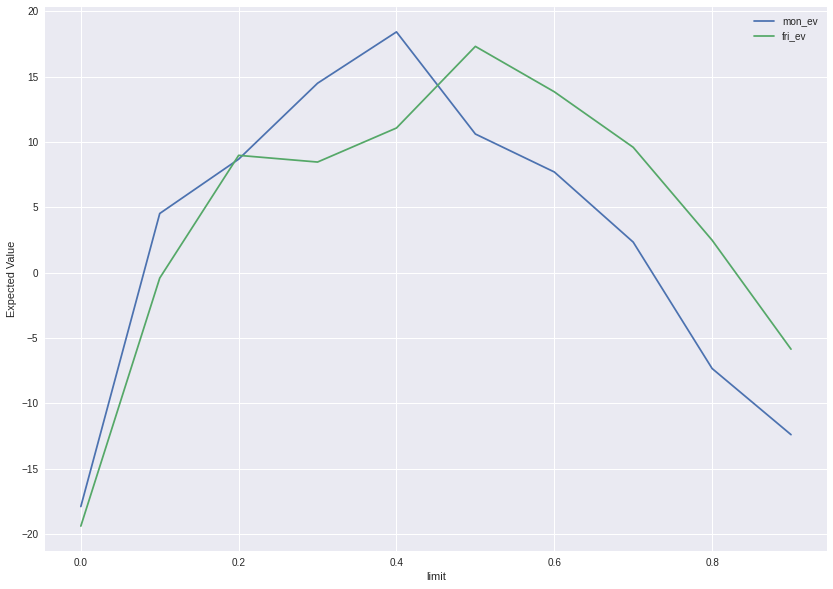

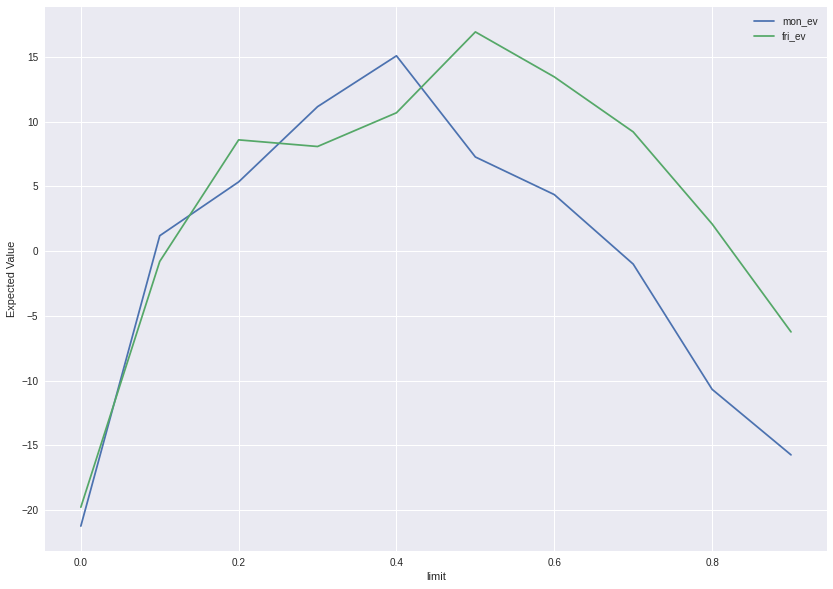

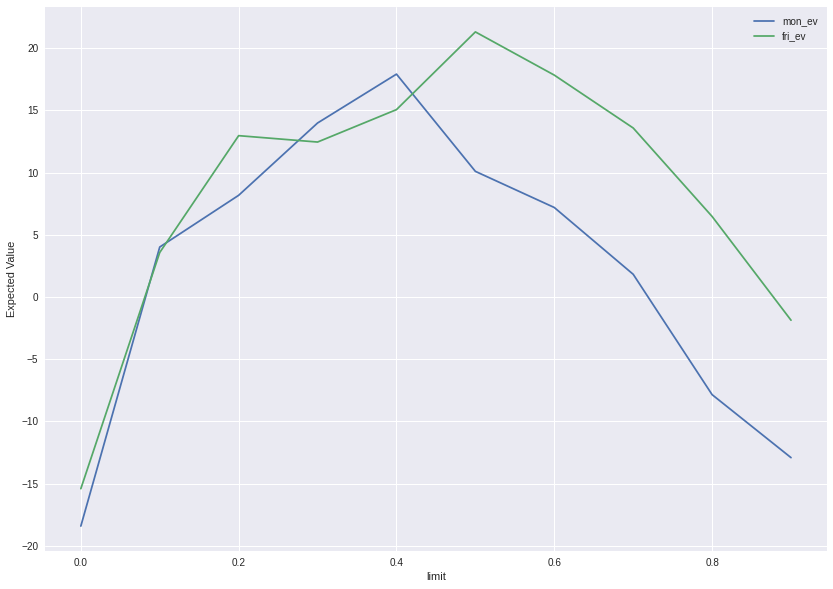

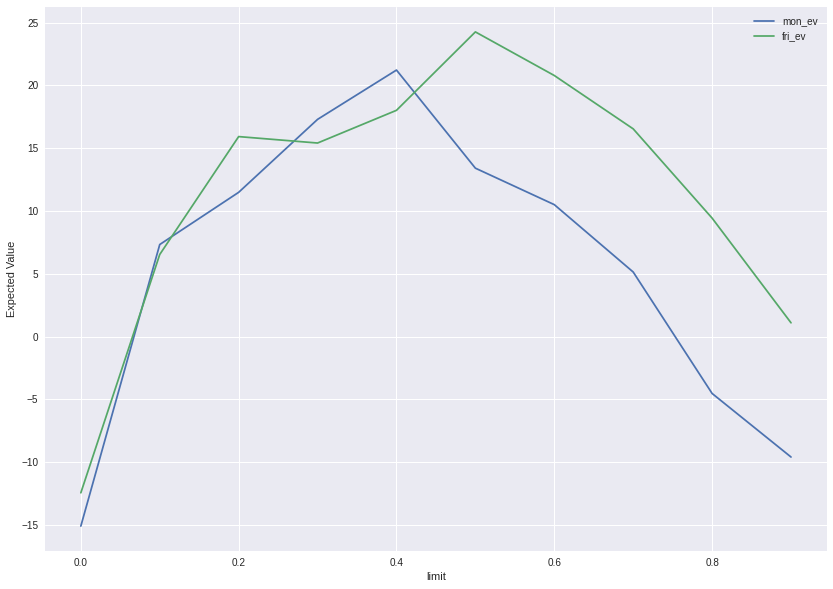

In [20]:
dp.groupby('stop').plot(x='limit', y=['mon_ev', 'fri_ev'], ylabel='Expected Value', figsize=graph_size)

In [45]:
trade = get_trades(prices[prices.time > dt.datetime(2020, 1, 1)], stop_quantile=0.7, limit_quantile=0.2)
trade

,day,direction,stop,limit,risk_reward_ratio,expected_value
0,Monday,buy,70.78,132.88,1.877366,5.342
1,Friday,sell,65.92,141.82,2.151396,8.588


In [22]:
api = login()
pos = api.positions()
accounts = api.accounts()[0]['accounts']
account_balance = accounts[0]['balance']['balance']

In [23]:
target_risk = 0.08

pos['value_at_risk'] = pos.contractSize * pos.stop_distance
suggested_size = account_balance * target_risk / pos.stop_distance.values[0]
print(suggested_size)
pos.value_at_risk.values[0] / account_balance * 100

-0.5828951911220689


-6.862297134927515

In [24]:
direction = 'buy'
t_dets = trade[trade.direction == direction]
backtest_trade(prices, direction=direction, stop=t_dets.stop.values[0], limit=t_dets.limit.values[0])

Summary of profit for buy (stop: 92.01999999999992, limit: 57.000000000000455):
count      40.000000
sum       137.440000
mean        3.436000
median     29.750000
std        59.239994
Name: trade, dtype: float64



In [25]:
prices

,time,volume,open_bid,open_ask,close_bid,close_ask,high_bid,high_ask,low_bid,low_ask,buy_profit,buy_stop,buy_limit,sell_profit,sell_stop,sell_limit,trade
0,2020-01-01,0,7559.0,7563.0,7556.2,7560.2,7567.3,7571.3,7553.2,7557.2,-6.8,-9.8,4.3,-1.2,12.3,-1.8,-6.8
1,2020-01-02,91282,7556.1,7560.1,7623.1,7627.1,7634.6,7638.6,7546.3,7549.3,63.0,-13.8,74.5,-71.0,82.5,-6.8,57.0
2,2020-01-03,80558,7622.9,7626.9,7599.2,7603.2,7632.8,7635.8,7548.8,7549.8,-27.7,-78.1,5.9,19.7,12.9,-73.1,-27.7
3,2020-01-05,0,7576.1,7580.1,7593.3,7597.3,7595.6,7599.6,7567.4,7571.4,13.2,-12.7,15.5,-21.2,23.5,-4.7,13.2
4,2020-01-06,80460,7593.7,7597.7,7584.6,7588.6,7598.0,7599.0,7525.8,7526.8,-13.1,-71.9,0.3,5.1,5.3,-66.9,-13.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,2020-09-30,106839,5906.2,5910.2,5868.1,5872.1,5932.7,5935.5,5833.6,5837.6,-42.1,-76.6,22.5,34.1,29.3,-68.6,-42.1
234,2020-10-01,88219,5868.3,5872.3,5877.2,5881.2,5927.2,5928.2,5847.7,5848.7,4.9,-24.6,54.9,-12.9,59.9,-19.6,4.9
235,2020-10-02,89003,5877.3,5881.3,5907.9,5911.9,5916.9,5920.9,5793.4,5796.4,26.6,-87.9,35.6,-34.6,43.6,-80.9,26.6
236,2020-10-04,0,5922.0,5926.0,5928.5,5932.5,5931.1,5935.1,5915.4,5919.4,2.5,-10.6,5.1,-10.5,13.1,-2.6,2.5


In [26]:
print('Monday Trades:')
mondays[[c for c in mondays.columns if 'buy' in c]].describe()

Monday Trades:


,buy_profit,buy_stop,buy_limit
count,40.000000,40.000000,40.000000
mean,31.250000,-71.565000,82.982500
std,109.644086,106.741212,80.475965
min,-254.600000,-533.200000,-6.600000
25%,-28.125000,-83.225000,24.375000
50%,35.200000,-26.900000,57.000000
75%,98.650000,-15.375000,128.400000
max,235.000000,-4.400000,317.000000


In [27]:
api = login()
api.positions()

,bid,epic,instrumentName,offer,dealId,direction,level,limitLevel,contractSize,stopLevel,close_level,profit,stop_distance,limit_distance
0,5929.6,IX.D.FTSE.DAILY.IP,FTSE 100,5933.6,DIAAAAFMGDXM6AQ,BUY,5925.5,5998.5,0.5,5848.5,5929.6,2.05,-81.1,68.9


In [28]:
pos = api.positions()

#### Trade Conditions
Set the stop and limit distances for the trades and append resulting profit in new column

In [29]:
backtest_trade(mondays, stop=50, limit=250)
backtest_trade(fridays, direction='sell', stop=36, limit=250)
print(mondays.trade.mode())
fridays.trade.value_counts().sort_index()

Summary of profit for buy (stop: 50, limit: 250):
count       40.000000
sum       1355.400000
mean        33.885000
median      27.150000
std         87.367786
Name: trade, dtype: float64

Summary of profit for sell (stop: 36, limit: 250):
count      39.000000
sum       829.400000
mean       21.266667
median     -8.800000
std        73.044861
Name: trade, dtype: float64

0   -50.0
dtype: float64


-36.0     19
-8.8       1
 3.4       1
 7.3       1
 19.7      1
 25.4      1
 30.9      1
 31.8      1
 45.4      1
 52.5      1
 64.7      1
 70.7      1
 74.2      1
 74.9      1
 96.1      1
 102.7     1
 108.3     1
 122.0     1
 165.6     1
 176.6     1
 250.0     1
Name: trade, dtype: int64

## Coins

In [30]:
from pprint import pprint

url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
api_key = '7229e9b5-38ba-4697-95bb-85c6d16c1f38'

parameters = {
  'start':'1',
  'limit':'5000',
  'convert':'USD'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': api_key,
}

session = requests.Session()
session.headers.update(headers)

request = session.get(url)

if request.status_code == 200:
    df = pd.DataFrame(request.json()['data'])
else:
    print(request.status_code, request.reason, request.text)

df.quote.apply(pd.Series)['USD'].apply(pd.Series)

,price,volume_24h,percent_change_1h,percent_change_24h,percent_change_7d,market_cap,last_updated
0,10662.078545,7.151081e+10,-0.031395,1.141336,-0.844927,1.973300e+11,2020-10-04T23:29:23.000Z
1,352.686527,1.102172e+10,0.015778,1.187910,-0.800805,3.980691e+10,2020-10-04T23:30:25.000Z
2,1.001292,3.066841e+10,-0.008303,0.018612,-0.047101,1.559504e+10,2020-10-04T23:30:24.000Z
3,0.248332,1.879128e+09,-0.172051,6.371388,2.312712,1.121527e+10,2020-10-04T23:30:24.000Z
4,28.982064,5.258267e+08,0.213975,4.165059,11.247175,4.185200e+09,2020-10-04T23:30:35.000Z
...,...,...,...,...,...,...,...
95,0.004783,6.660960e+06,2.126174,0.831626,-6.762907,9.996562e+07,2020-10-04T23:29:56.000Z
96,0.158306,6.700880e+05,-0.222060,2.365490,2.586430,9.852042e+07,2020-10-04T23:29:55.000Z
97,3.957734,1.306584e+07,-0.384668,-2.129828,-13.821335,9.696448e+07,2020-10-04T23:29:44.000Z
98,0.263705,5.018925e+06,-1.072415,-2.471407,-9.709005,9.693366e+07,2020-10-04T23:30:39.000Z


In [31]:
index = 0
name = 'Bitcoin'
symbol = 'BTC'
percent1h = 0.012
percent24h = 0.498

tweet = f'Rank: #{index + 1}\n'
tweet += f'Crypto: {name}\n'
tweet += f'Symbol: {symbol}\n'
tweet += f'1h change: {percent1h:.3f}%\n'
tweet += '24h change: {:.3f}%\n'.format(percent24h)
print(tweet)

Rank: #1
Crypto: Bitcoin
Symbol: BTC
1h change: 0.012%
24h change: 0.498%



In [32]:
import pandas as pd

str_time = '2020-08-30T09:52:23.000Z'
t = pd.to_datetime(str_time)
print(t.strftime('%d-%m-%Y'))

30-08-2020


In [33]:
import time
import numpy as np

num_iterations = 30
num_loops = 2
IDs = np.random.randint(0, 11, size=(num_iterations * num_loops))
delay = 15

print(IDs)
for i in range(num_loops):
    for ID in IDs[i * num_iterations:(i + 1) * num_iterations]:
        print(i, ID)
    
    print(f'Sleeping for {delay} seconds...')
    time.sleep(delay)

[ 7  1  7  4  8 10  8  2  8  9 10  0 10  9  6  9  2  8  6  7  5  3  9  0
  9 10  9  1  2  9  6 10  2  6  1  3  4 10  6  8  2  6  6  4  4  9  3  3
  1  5  6  9 10  6  0  7  4  2  6  9]
0 7
0 1
0 7
0 4
0 8
0 10
0 8
0 2
0 8
0 9
0 10
0 0
0 10
0 9
0 6
0 9
0 2
0 8
0 6
0 7
0 5
0 3
0 9
0 0
0 9
0 10
0 9
0 1
0 2
0 9
Sleeping for 15 seconds...
1 6
1 10
1 2
1 6
1 1
1 3
1 4
1 10
1 6
1 8
1 2
1 6
1 6
1 4
1 4
1 9
1 3
1 3
1 1
1 5
1 6
1 9
1 10
1 6
1 0
1 7
1 4
1 2
1 6
1 9
Sleeping for 15 seconds...
